# Category Judgements

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import copy
import csv

In [103]:
train=pd.read_csv('X.csv', header=None, names=['Weight', 'Height', 'Class'])
test=pd.read_csv('y.csv', header=None, names=['Weight', 'Height'])
test

,Weight,Height
0,74,67
1,69,63
2,92,81
3,64,61
4,66,84
5,76,68
6,61,58
7,64,76
8,68,66
9,34,61


In [12]:
'''Splitting data w.r.t 3 category '''
features_label_1=train[train.Class==1][['Weight', 'Height']]
features_label_2=train[train.Class==2][['Weight', 'Height']]
features_label_3=train[train.Class==3][['Weight', 'Height']]

Psychological distance between exemplar x and stimulus y is defined as follows:-

$ d(x,y)= \Sigma_i \alpha_i(x_i - y_i)  $ 

where:-
$ \alpha_i $= Attention weights indicating how much should we weigh in a particular feature based on bias of judge


In [13]:
def psy_dist(x,y):
    '''Calculates psychological distance between exemplar x and stimulus y '''
    
    x=np.array(x)
    y=np.array(y)
    return np.abs(np.sum(np.multiply(alpha, x-y)))



Similarity between exemplar x and feature y is given by:-

$ s(x,y) = e^{-\beta d(x,y} $

$ \beta $= Reflecting Bias-Variance Tradeoff in similarity judgements

In [14]:
def similarity(x,y):
    '''Calculates the similarity b/w exemplar x and stimulus y'''
    return np.exp(-Beta*psy_dist(x,y))
    
    

Now, given a stimulus y, we'll try to find out the probability of y belonging to a particular category R using the following formula:-

$ P(R |y) = \frac{\gamma_R \Sigma_{x \in R} N(R,x)s(x,y)}{\Sigma_r \gamma_r \Sigma_{k \in r} N(r,k) s(k,y)} $

$ N(R,x) $= Numer of times "x" has been labelled as R

In [15]:
def voting(y, category, gamma):
    '''Computes how similar a stimulus is to an exemplar and how likely is it for the stimulus to be classified as a particular exemplar'''
    if (category==1):
        features=features_label_1
    elif(category==2):
        features=features_label_2
    else:
        features=features_label_3
    
    vote=0
    for x in features.iterrows():
        x_vect=[x[1].Weight, x[1].Height]
        N_R_x=len(features[(features['Weight']==x[1].Weight) & (features['Height']==x[1].Height)])
        vote+= N_R_x*similarity(x_vect, y)
        
    
    return gamma*vote
    
    

    

In [16]:
def prob(y):
    '''P(R|y)'''
    cat_1=voting(y,1,gamma_small)
    cat_2=voting(y,2,gamma_avg)
    cat_3=voting(y,3,gamma_big)
    tot=cat_1+cat_2+cat_3
    return [cat_1/tot, cat_2/tot, cat_3/tot]
    

2 Features are:-

(i) Height:- Alpha value less as compared to weight
(ii) Weight:- Alpha value more as the subject is more inclined towards using weights to make judgements

3 Categories are:-

(i) Small:- Can be anything

(ii) Average:- Gamma value for Average will be more that that of Big as the subject is polite

(iii) Big:- Lesser than Average


In [47]:
gamma_small=0.1
gamma_avg=0.6
gamma_big=0.3

alpha=[0.8, 0.2]

Beta=5

In [19]:
print("Predicted labels for stimuli are:-")
for y in test.iterrows():
    y_vect=[y[1].Weight, y[1].Height]
    print("Stimulus=",y_vect,"Category=",np.argmax(prob(y_vect))+1)

Predicted labels for stimuli are:-
Stimulus= [74, 67] Category= 2
Stimulus= [69, 63] Category= 2
Stimulus= [92, 81] Category= 3
Stimulus= [64, 61] Category= 2
Stimulus= [66, 84] Category= 2
Stimulus= [76, 68] Category= 3
Stimulus= [61, 58] Category= 2
Stimulus= [64, 76] Category= 2
Stimulus= [68, 66] Category= 2
Stimulus= [34, 61] Category= 1


$ n_k $: Number of objects in category k

$ \alpha_j $ : corresponding to weight will be more than that of height

$ c $: Prob of 2 objects belonging to the same cluster or coupling probability

Let's assume weights and heights are discrete valued features

## Intuition behind the iterative procedure:-

Use the training set to find optimal set of partiions(or clusters) into which the dataset can be grouped.

For the test set, use the already created partitions, factor in the partition prior(or how likely is that partition, Note:- this has already been computed during the training phase) for all the  partitions and multiply it by how many objects in the partition have the same output label as that of the test stimuli.




Shape of alpha = # of features* Domain of features


In [108]:
train=train.to_numpy().tolist()
test=test.to_numpy().tolist()

In [21]:
test

[[74, 67],
 [69, 63],
 [92, 81],
 [64, 61],
 [66, 84],
 [76, 68],
 [61, 58],
 [64, 76],
 [68, 66],
 [34, 61]]

# Rational Model of Categorization

Prior Probability of Category k:
$ P(k) = \frac{cn_k}{(1-c)+cn} $

Prior Probability that we need a brand new category:
$ P(0)= \frac{1-c}{1-c+cn} $

Probability of displaying value "j" on dimension "i" given it comes from category k:
$ P_i(j|k)=\frac{c_i+\alpha_j}{n_k+\alpha_0} $

Probability of displaying features along dimensions given category membership:
$ P(F|k)= \Pi_i P_i(j|k) $

Probability of a new object coming from category "k" given its features:-
$ P(k|F)=\frac{P(k)P(F|k)}{\Sigma_k P(k)P(F|k)} $

Where:

**n_k**= Number of items in category/partition k so far

**c**= Coupling Probability or probability that 2 objects come from same category

**c_i**= Number of objects in category k with same value as object to be classified

**i**= dimension index

In [124]:

# Implementation of Anderson's venerable "rational" model of categorization.
# Assumes that stimuli were generated by a mixture of Gaussian distributions;
# rather than compute the full Bayesian posterior, it views items sequentially
# and assigns each to the maximum a posteriori cluster.
#
# At the end it is presented with a stimulus with one item missing, and
# predicts the probability that its value is a '0' or a '1'.
#
# Implemented in python by John McDonnell
#
# References: Anderson (1990) and Anderson (1991),

import numpy as np
from random import shuffle

#Utility functions:

class dLocalMAP:
    """
    See Anderson (1990, 1991)
    'Categories' renamed 'clusters' to avoid confusion.
    Discrete version.
    
    Stimulus format is a list of integers from 0 to n-1 where n is the number
    of possible features (e.g. [1,0,1])
    
    args: c, alphas
    """
    
    def __init__(self, args):
        self.partition = [[]]
        self.c, self.alpha = args
        self.alpha0 = [sum(x) for x in self.alpha]
        self.N = 0
    
    
    
    def probClustVal(self, k, i, val): 
        """Find P(j|k)"""
        
        cj = len([x for x in self.partition[k] if x[i]==val])
        nk = len(self.partition)
        return (cj + self.alpha[i][val])/(nk + self.alpha0[i])
        
        
            
    
    def condclusterprob(self, stim, k): 
        """Find P(F|k)"""
        pjks = []
       
        for i in range(len(stim)):
            cj = len([x for x in self.partition[k] if x[i]==stim[i]])
            nk = len(self.partition[k])
            pjks.append( (cj + self.alpha[i][stim[i]])/(nk + self.alpha0[i]) )
        return np.product( pjks )
        
    
    def posterior(self, stim):
        """Find P(k|F) for each cluster"""
        pk = np.zeros( len(self.partition) )
        pFk = np.zeros( len(self.partition) )
        
        # existing clusters:
        for k in range(len(self.partition)):
            pk[k] = self.c * len(self.partition[k])/ ((1-self.c) + self.c * self.N)
            if len(self.partition[k])==0: # case of new cluster
                pk[k] = (1-self.c) / (( 1-self.c ) + self.c * self.N)
            pFk[k] = self.condclusterprob( stim, k)
        
        # put it together
        pkF = (pk*pFk) / sum( pk*pFk )
        
        return pkF
    
    def stimulate(self, stim, simulation=False):
        """Argmax of P(k|F) + P(0|F)"""
        winner = np.argmax( self.posterior(stim) )
        post=self.posterior(stim)
        if(simulation==False):
            print ("Stim: ", stim)
            print ("Partition: ", self.partition)
            print (post)
        
        if len(self.partition[winner]) == 0:
            self.partition.append( [] )
        self.partition[winner].append(stim)
        
        self.N += 1
    
    def query(self, stimulus):
        """Queried value should be -1."""
        qdim = -1
        for i in range(len(stimulus)):
            if stimulus[i] < 0:
                if qdim != -1:
                    raise Exception("ERROR: Multiple dimensions queried.")
                qdim = i
        
        self.N = sum([len(x) for x in self.partition])
        
        pkF = self.posterior(stimulus)
        pkF = pkF[:-1] / sum(pkF[:-1]) # eliminate `new cluster' prob
        
        
        pjF = np.array( [sum( [ pkF[k] * self.probClustVal(k, qdim, j) \
                for k in range(len(self.partition)-1)] ) 
                for j in range(len( self.alpha[qdim] ))] )
      
        return pjF / sum(pjF)

def testlocalmapD(simulation=False):
    """
    Tests the Anderson's ratinal model using the Medin & Schaffer (1978) data.
    
    This script will print out the probability that each item belongs to each
    of the existing clusters or to a new cluster, and the model assign it to
    the most likely cluster. To see that the model is working correctly, you
    can follow along with Anderson (1991), which steps through in the same way.
    """
#     stims = [[1, 1, 1, 1, 1], # Medin & Schaffer (1978)
#              [1, 0, 1, 0, 1], 
#              [1, 0, 1, 1, 0],
#              [0, 0, 0, 0, 0],
#              [0, 1, 0, 1, 1],  
#              [0, 1, 0, 0, 0]]
    
#     stims= train
    # These are the classic Shepard Type II and Type IV datasets.
    # Uncomment the one you want to try out; you might want to uncomment
    # shuffling the stims too if you don't care about order.
    #stims = [[0, 0, 0, 0], [0, 0, 1, 0], [1, 1, 0, 1], [1, 1, 1, 1], [1, 0, 0, 0], [1, 0, 1, 1], [0, 1, 0, 0], [0, 1, 1, 1]] # Type IV
#     stims = [[0, 0, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1, 1]] # Type II
    
#     for _ in range(1):
        
        
    alpha=[[0.05]*100,[0.025]*100, [1,1,0.5]] #Weight is weighted more and label 2 is more likely as the judge is polite
    
    model = dLocalMAP([.5, alpha])
        
#     shuffle(train)
      
    stim=copy.deepcopy(train)
    
    
    for i in stim:
        i[2]-=1
     
    
    for s in stim:
        model.stimulate(s, simulation)
    if(simulation==False):
        print (model.partition)


    print("*************************************************************************")
    predictions=[]
    for t in test:
            
#             print(model.query(t+[-1]))
        cat=np.argmax(model.query(t+[-1]))+1
        print("Stimulus=",t,"Category Prediction=",cat)
        predictions.append(cat)
#             model.stimulate(t+[cat])
    
    
    return predictions
        
       
def main():
    testlocalmapD()

if __name__ == '__main__':
    main()


Stim:  [81, 69, 2]
Partition:  [[]]
[1.]
Stim:  [81, 71, 2]
Partition:  [[[81, 69, 2]], []]
[0.96401028 0.03598972]
Stim:  [67, 66, 1]
Partition:  [[[81, 69, 2], [81, 71, 2]], []]
[0.30599755 0.69400245]
Stim:  [78, 67, 2]
Partition:  [[[81, 69, 2], [81, 71, 2]], [[67, 66, 1]], []]
[0.60736473 0.11713463 0.27550064]
Stim:  [52, 65, 0]
Partition:  [[[81, 69, 2], [81, 71, 2], [78, 67, 2]], [[67, 66, 1]], []]
[0.21372823 0.23456795 0.55170382]
Stim:  [67, 67, 1]
Partition:  [[[81, 69, 2], [81, 71, 2], [78, 67, 2]], [[67, 66, 1]], [[52, 65, 0]], []]
[0.4516708  0.50780178 0.01209052 0.0284369 ]
Stim:  [48, 56, 0]
Partition:  [[[81, 69, 2], [81, 71, 2], [78, 67, 2]], [[67, 66, 1], [67, 67, 1]], [[52, 65, 0]], []]
[0.14462364 0.16460398 0.31745054 0.37332183]
Stim:  [47, 59, 0]
Partition:  [[[81, 69, 2], [81, 71, 2], [78, 67, 2]], [[67, 66, 1], [67, 67, 1]], [[52, 65, 0]], [[48, 56, 0]], []]
[0.10977539 0.1249413  0.24095822 0.24095822 0.28336687]
Stim:  [64, 63, 1]
Partition:  [[[81, 69, 2]

## Hyperparameter values for the inferences below are:-

1. Coupling Probability(c)=0.5 (Or assuming a stimulus can come from any category uniformly)
2. Alpha Values= 0.05 for weights and 0.025 for heights to factor in the prevalent parameter used by the judge
   and label 3 has a lesser weight than label 2 as the judge is polite

## Inference 

If we observe the dataset, we can find a majority of 2's, followed by 3's and so the partitions that are formed have most probably have a majority of 2's or 3's that leads to most of the predictions being 2's or 3's with a very less samples predicted as a 1. 

# Demonstrating exchangeability of data

In the following segment, we'll shuffle the order of test and training datastream and run experiments on both gcm and rmc to observe the results.

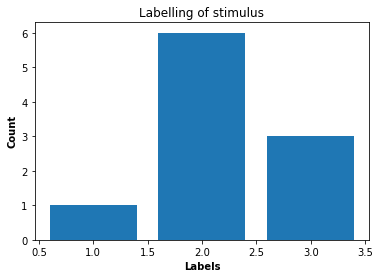

******** End of Experiment 1 ***********


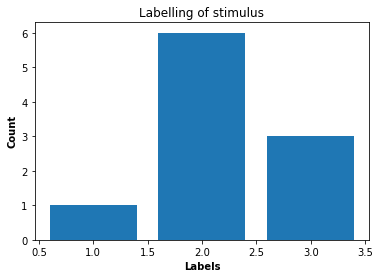

******** End of Experiment 2 ***********


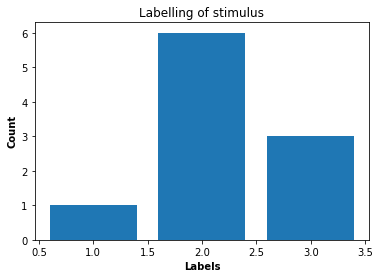

******** End of Experiment 3 ***********


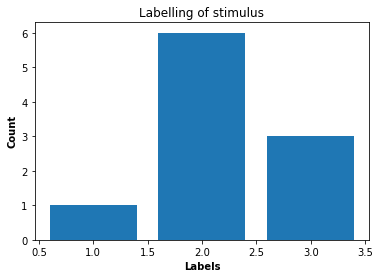

******** End of Experiment 4 ***********


In [125]:
#For GCM
for expt in range(4):
    shuffle(test)
    count=[]
    for y in test:
        count.append(np.argmax(prob(y))+1)
#         print("Stimulus=",y,"Category=",np.argmax(prob(y))+1)
    
    c=collections.Counter(count)
    c=sorted(c.items())
    plt.bar([i[0] for i in c], [i[1] for i in c])
    plt.xlabel('Labels', fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    plt.title('Labelling of stimulus')
    plt.show()
    
        
    print("********","End of Experiment",expt+1,"***********")



## Inference for GCM(On permuting either training or test set)

As we can observe from the plots, the label count for each experiment remains unchanged. This happens as GCM works like KNN where there's no training taking place, and the labels are granted to a stimulus based on the closest exemplar. The notion of closeness is calculated using similarity function and a label is granted based on the highest probability which is a function of similarities between the stimulus and the exemplar and how many times the exemplar has been categorized with a particular label(this remains unchanged as the probability is solely depending on the exemplars, which remains static througout).

*************************************************************************
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 2


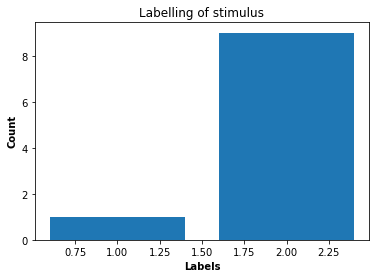

******** End of Experiment 1 ***********
*************************************************************************
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 2
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 2


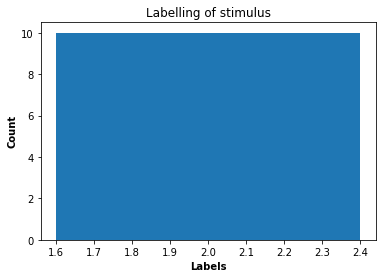

******** End of Experiment 2 ***********
*************************************************************************
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [76, 68] Category Prediction= 3
Stimulus= [69, 63] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 1
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 1


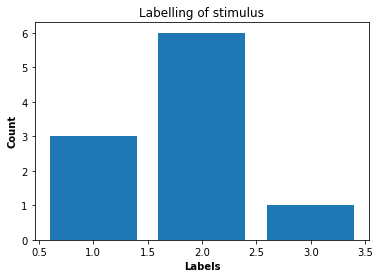

******** End of Experiment 3 ***********
*************************************************************************
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 3
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 2


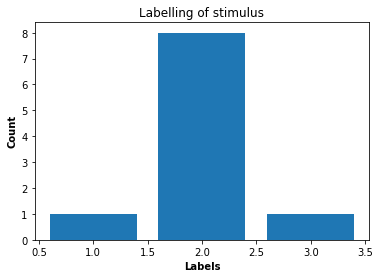

******** End of Experiment 4 ***********


In [127]:
for expt in range(4):
    shuffle(train)
    pred=testlocalmapD(True)
    c=collections.Counter(pred)
   
    c=sorted(c.items())
#     plt.hist(pred)
    plt.bar([i[0] for i in c], [i[1] for i in c])
    plt.xlabel('Labels', fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    plt.title('Labelling of stimulus')
    plt.show()
    
      
    print("********","End of Experiment",expt+1,"***********")

## Inference in RMC(On permuting training set)

As partitions are formed based on how exemplars are appearing, we can observe that the labelling outcome of the experiments differ based on the partitioning formed and where the stimulus is going. Then a majority voting takes place.

*************************************************************************
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 3
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [76, 68] Category Prediction= 2
[2, 3, 2, 2, 2, 1, 2, 2, 2, 2]


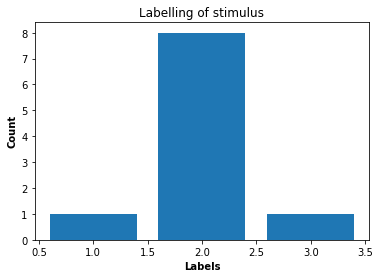

******** End of Experiment 1 ***********
*************************************************************************
Stimulus= [92, 81] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 3
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [64, 76] Category Prediction= 2
[2, 2, 2, 3, 2, 2, 2, 1, 2, 2]


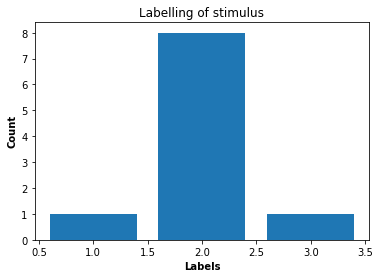

******** End of Experiment 2 ***********
*************************************************************************
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [92, 81] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [69, 63] Category Prediction= 3
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [64, 76] Category Prediction= 2
[1, 2, 2, 3, 2, 2, 2, 2, 2, 2]


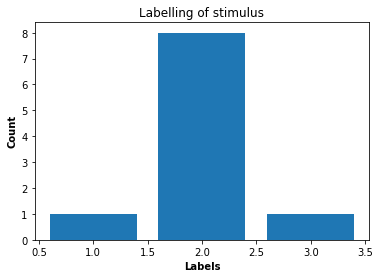

******** End of Experiment 3 ***********
*************************************************************************
Stimulus= [69, 63] Category Prediction= 3
Stimulus= [68, 66] Category Prediction= 2
Stimulus= [92, 81] Category Prediction= 2
Stimulus= [34, 61] Category Prediction= 2
Stimulus= [61, 58] Category Prediction= 1
Stimulus= [64, 76] Category Prediction= 2
Stimulus= [74, 67] Category Prediction= 2
Stimulus= [66, 84] Category Prediction= 2
Stimulus= [76, 68] Category Prediction= 2
Stimulus= [64, 61] Category Prediction= 2
[3, 2, 2, 2, 1, 2, 2, 2, 2, 2]


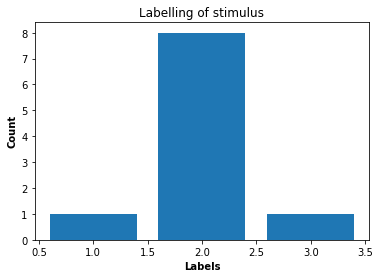

******** End of Experiment 4 ***********


In [128]:
for expt in range(4):
    shuffle(test)
    pred=testlocalmapD(True)
    c=collections.Counter(pred)
    print(pred)
    c=sorted(c.items())
#     plt.hist(pred)
    plt.bar([i[0] for i in c], [i[1] for i in c])
    plt.xlabel('Labels', fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    plt.title('Labelling of stimulus')
    plt.show()
    
      
    print("********","End of Experiment",expt+1,"***********")

## Inference in RMC(on permuting the test set)

During the training phase, the dataset is partitioned into majorly 2-3 partitions and as label "2" is a clear majority in the dataset i.e. 40 items, mostly the partitions contains a majority of 2 and a significant number of stimulus is labelled as 2. shuffling the test set does not change the outcome if the training set is fixed, and a parition corresponding to a particular order of training set has already been created. This is because, once the partitions are fixed, stimulus will be going to the same partition irrespective of the order and then a majority voting count will take place resulting in the labelling. If we change it to an online setting where we update partitions based on the marked samples from test set, then changes might be observed

## References:

1. For GCM, lecture slides of April 08
2. For RMC, Paper[http://act-r.psy.cmu.edu/wordpress/wp-content/uploads/2012/12/89AdaptiveNature.pdf]

## Acknowledgements
I am thankful to my brainstorming mates, Sharanya and Manjyot for the wonderful discussion sessions :)